# Breast Cancer Segmentation
data set source: https://github.com/PathologyDataScience/BCSS

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/Breast Cancer"

/content/drive/MyDrive/Breast Cancer


In [ ]:
cd CrowdsourcingDataset-Amgadetal2019

/content/drive/MyDrive/Breast Cancer/CrowdsourcingDataset-Amgadetal2019


In [ ]:
!pip install girder_client girder-client pillow numpy scikit-image imageio tf2torch

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement tf2torch (from versions: none)
ERROR: No matching distribution found for tf2torch


## EDA

In [ ]:
import torch
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import os
import sys
import random
import warnings

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 21

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [ ]:
my_image = 'TCGA-AR-A2LH-DX1_xmin78480_ymin42305_MPP-0.2500.png'

In [ ]:
cwd = os.getcwd()
image_path = os.path.join(cwd,"images/",my_image)
mask_path = os.path.join(cwd,"masks/",my_image)

In [ ]:
image = cv2.imread(image_path)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
mask = (mask == 1).astype(np.uint8)

In [ ]:
# Initialize variables to store the maximum and minimum pixel values
max_pixel_value = 0
min_pixel_value = 255  # Assuming 8-bit images

# Loop through the image files in the directory
for filename in os.listdir('/content/drive/MyDrive/Breast Cancer/CrowdsourcingDataset-Amgadetal2019/masks'):
    if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        image_path_ = os.path.join('/content/drive/MyDrive/Breast Cancer/CrowdsourcingDataset-Amgadetal2019/masks', filename)

        # Read the image using OpenCV
        image_ = cv2.imread(image_path_)

        if image_ is not None:
            # Find the maximum and minimum pixel values in the image
            max_value = np.max(image_)
            min_value = np.min(image_)

            # Update the overall maximum and minimum pixel values
            max_pixel_value = max(max_pixel_value, max_value)
            min_pixel_value = min(min_pixel_value, min_value)

print(f"Maximum pixel value: {max_pixel_value}")
print(f"Minimum pixel value: {min_pixel_value}")

Maximum pixel value: 20
Minimum pixel value: 0


In [ ]:
image.shape

(3134, 4407, 3)

In [ ]:
mask.shape

(3134, 4407)

In [ ]:
image.max()

255

In [ ]:
mask.max()

1

In [ ]:
image.min()

1

In [ ]:
mask.min()

0

In [ ]:
mask_interactive = cv2.resize(mask, (512, 512))

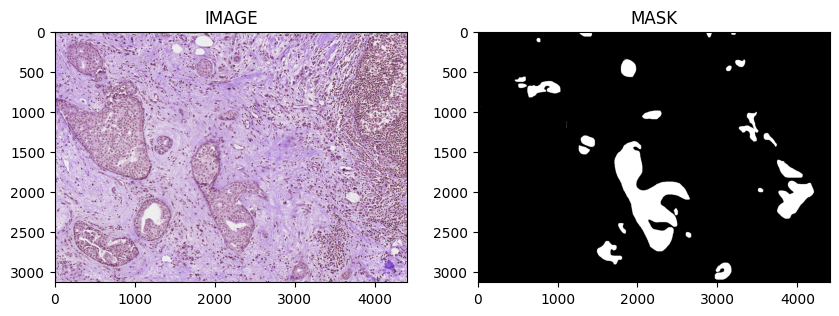

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
import plotly.express as px
mask_interactive = cv2.resize(mask, (512, 512))
fig = px.imshow(mask_interactive, color_continuous_scale="sunsetdark")
fig.show()
#value is (0-21)/255

In [ ]:
image_path = os.path.join(cwd,"images/")

image_list = [cwd+"/images/"+f for f in os.listdir(image_path)]
mask_list = [cwd+"/masks/"+f for f in os.listdir(image_path)]

df = pd.DataFrame({"image": image_list,"mask": mask_list})

In [ ]:
row = df.iloc[30]

image = cv2.imread(row["image"])
mask = cv2.imread(row["mask"], cv2.IMREAD_GRAYSCALE)
mask = (mask == 1).astype(np.uint8)

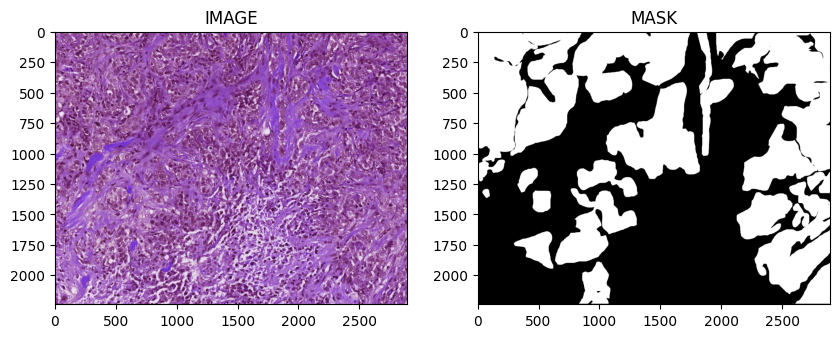

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
mask_interactive = cv2.resize(mask, (512, 512))
fig = px.imshow(mask_interactive, color_continuous_scale="sunsetdark")
fig.show()

In [ ]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state=42)

In [ ]:
len(train_df)

120

In [ ]:
len(valid_df)

31

### Augmentation

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(width=512, height=512),
      A.RandomBrightnessContrast(p=1)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(width=512, height=512),
      A.RandomBrightnessContrast(p=1)
  ])

In [ ]:
from torch.utils.data import Dataset
from albumentations import Compose, Resize
from albumentations.pytorch import ToTensorV2

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, df, num_classes):
        self.df = df
        self.num_classes = num_classes
        self.transform = Compose([Resize(512, 512),ToTensorV2()])

    def __len__(self):
        return len(self.df)

    def one_hot_encode(self, mask):
        mask = mask.squeeze()
        mask = mask.to(torch.int64)
        one_hot_mask = torch.zeros(self.num_classes, mask.size(0), mask.size(1))
        one_hot_mask = one_hot_mask.scatter(0, mask.unsqueeze(0), 1)
        return one_hot_mask

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        image_path = row["image"]
        mask_path = row["mask"]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # (h,w,c)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # (h,w)
        mask = (mask == 1).astype(np.uint8)
        mask = np.expand_dims(mask, axis=-1)  # (h,w,c)
        # mask = mask.permute(1,2,0)
        data = self.transform(image=image, mask=mask)
        image = data['image']  # (c, h, w)
        mask = data['mask']
        mask = mask.permute(2,0,1)
        # mask = self.one_hot_encode(mask)  # One-hot encode the mask

        return image.float(), mask.float()

In [ ]:
train_set = SegmentationDataset( train_df, 21)
valid_set = SegmentationDataset( valid_df, 21)

In [ ]:
print(f'Size of train set : {len(train_set)}' )
print(f'Size of valid set : {len(valid_set)}' )

Size of train set : 120
Size of valid set : 31


In [ ]:
import csv
from PIL import Image
tsv_file_path = "meta/gtruth_codes.tsv"
# Read the TSV file into a DataFrame
label_df = pd.read_csv(tsv_file_path, sep='\t')

In [ ]:
def show_image(image,mask,pred_image = None):
    # if mask.shape[0]==21:
    #     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

    #     ax1.set_title('IMAGE')
    #     ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

    #     ax2.set_title('MASK')
    #     # Define a colormap with 21 unique colors
    #     colormap = plt.cm.get_cmap('viridis', 21)

    #     # Create an empty combined image
    #     combined_image = torch.zeros(512, 512, 3)

    #     # Iterate through each layer and assign a unique color
    #     for i in range(21):
    #         layer = mask[i, :, :]
    #         color = np.array(colormap(i / 20.0))[:3]  # Extract the RGB color
    #         combined_image += layer.unsqueeze(2) * color  # Combine layers with different colors

    #     # Normalize the combined image to the range [0, 1]
    #     combined_image /= combined_image.max()

    #     # Display the combined image using Matplotlib
    #     ax2.imshow(combined_image.numpy(),cmap = 'gray')

    if pred_image == None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('MASK')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

            f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

            ax1.set_title('IMAGE')
            ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

            ax2.set_title('MASK')
            ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

            ax3.set_title('MODEL OUTPUT')
            ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [ ]:
def plot_layer(mask):
# Assuming you have a list of tensors (mask) with 21 elements
# Adjust the colormap and other parameters as needed
  cmap = 'viridis'
  num_images_per_row = 7

  # Create subplots for organizing the images
  fig, axs = plt.subplots(3,7, figsize=(12, 8))

  for i, (tensor, row) in enumerate(zip(mask, label_df.iterrows())):
      ax = axs[i // num_images_per_row, i % num_images_per_row]
      ax.imshow(tensor.squeeze().numpy(), cmap=cmap)
      label = row[1]['label']
      gt_code = row[1]['GT_code']
      ax.set_title(f'{label} ({gt_code})', fontsize=9)
      ax.axis('off')  # Turn off axis labels

  # Remove any empty subplots
  for i in range(len(mask), len(axs.ravel())):
      axs.flatten()[i].axis('off')

  plt.tight_layout()
  plt.show()

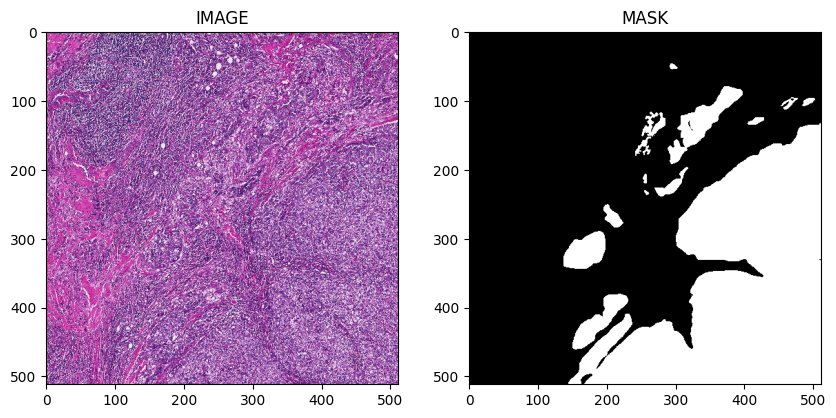

In [ ]:
idx = 77
image, mask = train_set[idx]
show_image(image/255, mask)

## Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
batch_size = 8
num_workers = 0

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
print(f'Total no. of batches in trainloader: {len(train_loader)}')
print(f'Total no. of batches in validloader: {len(valid_loader)}')

Total no. of batches in trainloader: 15
Total no. of batches in validloader: 4


In [ ]:
for images, masks in train_loader:
  print(f'One batch image shape : {images.shape}')
  print(f'One batch mask shape : {masks.shape}')
  break;

One batch image shape : torch.Size([8, 3, 512, 512])
One batch mask shape : torch.Size([8, 1, 512, 512])


### resnet50-unet


In [ ]:
!pip install segmentation-models-pytorch
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=1b0f2f13d9a82c7b9332275dd3df02bc81771eaf32c659b0a2181d4ff83a0b13
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=50564a6d8bee8428ddad80acd246b701a179937506e347a7747594481ca60827
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

In [ ]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from torch import nn

In [ ]:
device = 'cuda'

epochs = 10
lr = 0.001
batch_size = 8
img_size = 512

encoder = 'resnet50'
weight = 'imagenet'

In [ ]:
class Unet(nn.Module):
  def __init__(self):
    super(Unet,self).__init__()

    self.backbone = smp.Unet(
        encoder_name = encoder,
        encoder_weights = weight,
        in_channels= 3,
        classes =1,
        activation = None
    )

  def forward(self, images, masks = None):
     logits = self.backbone(images)

     if masks != None:
       return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)

     return logits

In [ ]:
model = Unet()
model.to()

Unet(
  (backbone): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

In [ ]:
def train_fn(dataloader, model, optimizer):
  model.train() # Turn ON dropout, batchnorm, etc...
  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to()
    masks = masks.to()
    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval_fn(dataloader, model):
  model.eval() # Turn OFF dropout, batchnorm, etc...
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to()
      masks = masks.to()
      logits, loss = model(images, masks)
      total_loss += loss.item()
  return total_loss / len(dataloader)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
best_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "resnet50_unet.pt")
    print("SAVED-MODEL")
    best_loss = valid_loss

  print(f"Epoch: {i+1} Trian Loss: {train_loss} Valid Loss: {valid_loss}")

In [ ]:
idx = 10

model.load_state_dict(torch.load('./resnet50_unet.pt'))
image, mask = valid_set[idx]

logits_mask = model(image.to().unsqueeze(0)) # (c,h,w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

In [ ]:
pred_mask_binary = (pred_mask > 0.8).float() * 255.0

output_mask = pred_mask_binary[0]
result = torch.where(pred_mask_binary < 255, image, output_mask)

In [ ]:
def dice_coefficient(A, B):
    # Convert A and B to binary masks (0 or 1)
    A_binary = (A > 0.5).float()  # Adjust the threshold as needed
    B_binary = (B > 0.5).float()

    intersection = torch.sum(A_binary * B_binary)
    union = torch.sum(A_binary) + torch.sum(B_binary)

    if union == 0:
        return 1.0  # Handle the case where both sets are empty
    else:
        return (2.0 * intersection) / union

In [ ]:
def accuracy(predicted_labels, ground_truth_labels):
    if len(predicted_labels) != len(ground_truth_labels):
        raise ValueError("Input lists must have the same length")

    correct_predictions = torch.sum(predicted_labels==ground_truth_labels)
    total_samples = 512*512
    accuracy_value = correct_predictions / total_samples
    return accuracy_value

In [ ]:
def calculate_confusion_matrix_and_metrics(y_true, y_pred):
    if y_true.size() != y_pred.size():
        raise ValueError("Input tensors must have the same size")

    true_positive = torch.sum((y_true == 1) & (y_pred == 1)).item()
    false_positive = torch.sum((y_true == 0) & (y_pred == 1)).item()
    true_negative = torch.sum((y_true == 0) & (y_pred == 0)).item()
    false_negative = torch.sum((y_true == 1) & (y_pred == 0)).item()

    confusion_matrix = torch.tensor([[true_negative, false_positive],
                                    [false_negative, true_positive]])

    precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0.0
    recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0.0

    return confusion_matrix, precision, recall


#### Evaluate resnet50_unet

In [ ]:
accuracy(mask,pred_mask[0])

tensor(0.8053)

In [ ]:
dice_coefficient(mask,pred_mask[0])

tensor(0.6743)

In [ ]:
nn.BCEWithLogitsLoss()(mask,pred_mask[0])

tensor(0.6438)

In [ ]:
confusion_matrix, precision, recall = calculate_confusion_matrix_and_metrics(mask,pred_mask[0])

In [ ]:
confusion_matrix

tensor([[158286,  39535],
        [ 11498,  52825]])

In [ ]:
precision

0.5719467301862278

In [ ]:
recall

0.8212458996004539

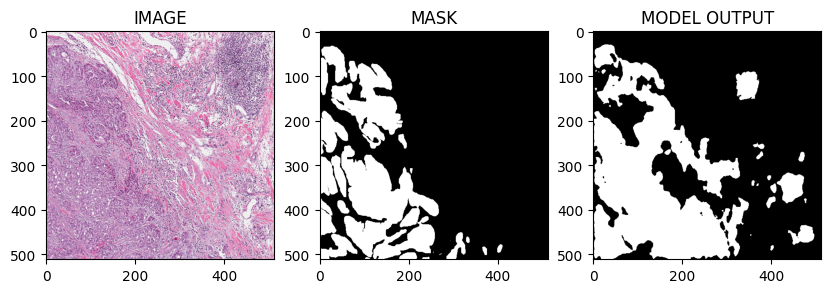

In [ ]:
show_image(image/255, mask,pred_mask[0])

### vgg16-unet


In [ ]:
device = 'cuda'

epochs = 10
lr = 0.001
batch_size = 8
img_size = 512

encoder = 'vgg16'
weight = 'imagenet'

In [ ]:
model = Unet()
model.to()

Unet(
  (backbone): Unet(
    (encoder): VGGEncoder(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [ ]:
best_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = eval_fn(valid_loader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "vgg16_unet.pt")
    print("SAVED-MODEL")
    best_loss = valid_loss

  print(f"Epoch: {i+1} Trian Loss: {train_loss} Valid Loss: {valid_loss}")

In [ ]:
idx = 10

model.load_state_dict(torch.load('./vgg16_unet.pt'))
image, mask = valid_set[idx]

logits_mask = model(image.to().unsqueeze(0)) # (c,h,w) -> (b, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

#### Evaluate vgg16_unet

In [ ]:
accuracy(mask,pred_mask[0])

tensor(0.8680)

In [ ]:
dice_coefficient(mask,pred_mask[0])

tensor(0.7831)

In [ ]:
nn.BCEWithLogitsLoss()(pred_mask[0],mask)

tensor(0.6800)

In [ ]:
confusion_matrix, precision, recall = calculate_confusion_matrix_and_metrics(mask,pred_mask[0])

In [ ]:
confusion_matrix

tensor([[165109,  32712],
        [  1884,  62439]])

In [ ]:
precision

0.6562096036825678

In [ ]:
recall

0.9707103213469521

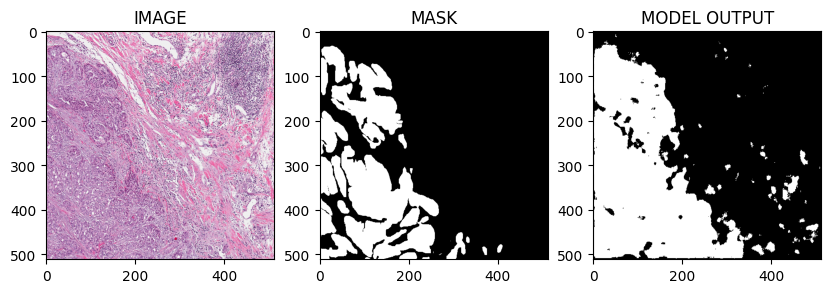

In [ ]:
show_image(image/255, mask,pred_mask[0])